## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings, json, re, glob, math
# from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
input_base_path = '/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/'
with open(input_base_path + 'config.json') as json_file:
    config = json.load(json_file)

config

{'HEIGHT': 384,
 'WIDTH': 384,
 'CHANNELS': 3,
 'BATCH_SIZE': 16,
 'EPOCHS': 30,
 'LEARNING_RATE': 0.005,
 'ES_PATIENCE': 20,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'DATASET_PATH': 'melanoma-384x384',
 'INFERENCE': True}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
test = pd.read_csv(database_base_path + 'test.csv')

print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
model_path_list = glob.glob(input_base_path + '*.h5')
model_path_list.sort()

print('Models to predict:')
print(*model_path_list, sep='\n')

Models to predict:
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_0_last.h5
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_1_last.h5
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_2_last.h5
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_3_last.h5
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_4_last.h5


# Augmentations

In [7]:
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [8]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    
    # Meta data
    meta_data = {}
    meta_data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    meta_data['sex'] = tf.cast(example['sex'], tf.int32)
    return {'input_image': example['image'], 'input_meta': meta_data}, example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    
    # Meta data
    meta_data = {}
    meta_data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    meta_data['sex'] = tf.cast(example['sex'], tf.int32)
    return {'input_image': example['image'], 'input_meta': meta_data}, example['image_name'] if return_image_name else 0
 
def prepare_image(data, augment=None, dim=256):
    # Image
    img = data['input_image']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim, dim, 3])
            
    # Meta
    meta = data['input_meta']
    meta = [tf.cast(meta[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'sex']]
    
    data['input_image'] = img
    data['input_meta'] = meta
    return data

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda data, imgname_or_label: (prepare_image(data, augment=augment, dim=dim), 
                                                imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


def get_dataset_sampling(files, augment=None, shuffle=False, repeat=False, 
                         labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda data, imgname_or_label: (prepare_image(data, augment=augment, dim=dim), 
                                                imgname_or_label), num_parallel_calls=AUTO)
    
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Model

In [9]:
def model_fn(image_input_shape=(256, 256, 3), meta_input_shape=(2)):
    input_image = L.Input(shape=image_input_shape, name='input_image')
    input_meta = L.Input(shape=meta_input_shape, name='input_meta')
    base_model = efn.EfficientNetB3(input_shape=image_input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False, 
                                    pooling='avg',
                                    drop_connect_rate=0.4)
    
    # Image block
    x = base_model(input_image)
    x = L.Dropout(0.2)(x)

    # Meta data block
    
    # Merge blocks
    x_merged = L.concatenate([x, input_meta])
    x_merged = L.Dense(512)(x_merged)
    x_merged = L.BatchNormalization()(x_merged)
    x_merged = L.Activation('relu')(x_merged)
    x_merged = L.Dropout(0.2)(x_merged)
        
    output = L.Dense(1, activation='sigmoid', kernel_initializer='zeros', name='output')(x_merged)

    model = Model(inputs=[input_image, input_meta], outputs=output)

    return model

# Inference

In [10]:
preds = np.zeros((len(test), 1))


for model_path in model_path_list:
    print(model_path)
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_test = count_data_items(TEST_FILENAMES)
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    
    
    # MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        
    model.load_weights(model_path)
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_0_last.h5
43933696/43933088 [==============================] - 1s 0us/step
Predicting Test with TTA...
537/536 - 201s
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_1_last.h5
Predicting Test with TTA...
537/536 - 184s
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_2_last.h5
Predicting Test with TTA...
537/536 - 183s
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_3_last.h5
Predicting Test with TTA...
537/536 - 183s
/kaggle/input/151-melanoma-5fold-efficientnetb3-meta-fts-384/model_4_last.h5
Predicting Test with TTA...
537/536 - 184s


# Visualize test predictions

Test predictions 500|10482
Top 10 samples


,image_name,target
9905,ISIC_0052060,0.022139
1443,ISIC_0052349,0.011869
3120,ISIC_0058510,0.013684
4870,ISIC_0073313,0.015554
5494,ISIC_0073502,0.014494
4537,ISIC_0074618,0.022379
4819,ISIC_0076801,0.155221
7203,ISIC_0077586,0.027530
10897,ISIC_0082004,0.133520
5093,ISIC_0082785,0.040013


Top 10 positive samples


,image_name,target
2280,ISIC_0112420,0.936803
1489,ISIC_0155813,0.578878
8522,ISIC_0155983,0.820366
1782,ISIC_0169906,0.592569
9528,ISIC_0178235,0.645430
8603,ISIC_0182213,0.572781
1215,ISIC_0200120,0.784184
2519,ISIC_0208233,0.653246
3184,ISIC_0216447,0.711525
9464,ISIC_0220438,0.916133


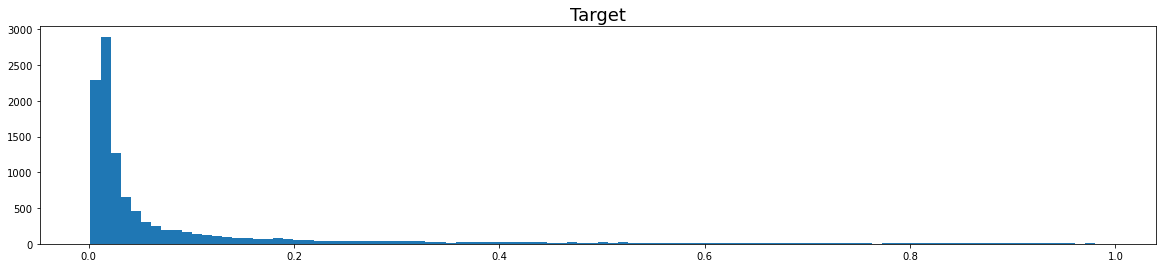

In [11]:
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target'], bins=100)
plt.title('Target', size=18)
plt.show()

# Test set predictions

In [12]:
display(submission.head(10))
display(submission.describe().T)

submission[['image_name', 'target']].to_csv('submission.csv', index=False)

,image_name,target
9905,ISIC_0052060,0.022139
1443,ISIC_0052349,0.011869
3120,ISIC_0058510,0.013684
4870,ISIC_0073313,0.015554
5494,ISIC_0073502,0.014494
4537,ISIC_0074618,0.022379
4819,ISIC_0076801,0.155221
7203,ISIC_0077586,0.027530
10897,ISIC_0082004,0.133520
5093,ISIC_0082785,0.040013


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.090256,0.16528,0.001809,0.012854,0.023313,0.07564,0.989792
